# A Step-by-Step Tutorial of Using VecKM on Your Own Point Cloud Data

In [2]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Step 1: Copy the code in the readme file.

In [3]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

def strict_standard_normal(d):
    # this function generate very similar outcomes as torch.randn(d)
    # but the numbers are strictly standard normal, no randomness.
    y = np.linspace(0, 1, d+2)
    x = norm.ppf(y)[1:-1]
    np.random.shuffle(x)
    x = torch.tensor(x).float()
    return x

class VecKM(nn.Module):
    def __init__(self, d=256, alpha=6, beta=1.8, p=4096):
        """ I tested empirically, here are some general suggestions for selecting parameters d and p:
        (alpha=6, beta=1.8) works for the data scale that your neighbordhood radius = 1.
        Please ensure your point cloud is appropriately scaled!
        d = 256, p = 4096 is for point cloud size ~20k. Runtime is about 28ms.
        d = 128, p = 8192 is for point cloud size ~50k. Runtime is about 76ms.
        For larger point cloud size, please enlarge p, but if that costs too much, please reduce d.
        A general empirical phenomenon is (d*p) is postively correlated with the encoding quality.

        For the selection of parameter alpha and beta, please see the github section below.
        """
        super().__init__()
        self.sqrt_d = d ** 0.5
        self.d = d

        self.A = torch.stack(
            [strict_standard_normal(d) for _ in range(3)], 
            dim=0
        ) * alpha
        self.A = nn.Parameter(self.A, False)                                    # (3, d)

        self.B = torch.stack(
            [strict_standard_normal(p) for _ in range(3)], 
            dim=0
        ) * beta
        self.B = nn.Parameter(self.B, False)                                    # (3, d)

    def forward(self, pts):
        """ Compute the dense local geometry encodings of the given point cloud.
        Args:
            pts: (bs, n, 3) or (n, 3) tensor, the input point cloud.

        Returns:
            G: (bs, n, d) or (n, d) tensor
               the dense local geometry encodings. 
               note: it is complex valued. 
        """
        pA = pts @ self.A                                                       # Real(..., n, d)
        pB = pts @ self.B                                                       # Real(..., n, p)
        eA = torch.concatenate((torch.cos(pA), torch.sin(pA)), dim=-1)          # Real(..., n, 2d)
        eB = torch.concatenate((torch.cos(pB), torch.sin(pB)), dim=-1)          # Real(..., n, 2p)
        G = torch.matmul(
            eB,                                                                 # Real(..., n, 2p)
            eB.transpose(-1,-2) @ eA                                            # Real(..., 2p, 2d)
        )                                                                       # Real(..., n, 2d)
        G = torch.complex(
            G[..., :self.d], G[..., self.d:]
        ) / torch.complex(
            eA[..., :self.d], eA[..., self.d:]
        )                                                                       # Complex(..., n, d)
        G = G / torch.norm(G, dim=-1, keepdim=True) * self.sqrt_d
        return G

vkm = VecKM()
pts = torch.rand((10,1000,3))
print(vkm(pts).shape) # it will be Complex(10,1000,256)
pts = torch.rand((1000,3))
print(vkm(pts).shape) # it will be Complex(1000, 256)

from complexPyTorch.complexLayers import ComplexLinear, ComplexReLU
# You may want to use apply two-layer feature transform to the encoding.
feat_trans = nn.Sequential(
    ComplexLinear(256, 128),
    ComplexReLU(),
    ComplexLinear(128, 128)
)
G = feat_trans(vkm(pts))
G = G.real**2 + G.imag**2 # it will be Real(10, 1000, 128) or Real(1000, 1024).

torch.Size([10, 1000, 256])
torch.Size([1000, 256])


### Step 2: Load our (your) example point cloud.

In [4]:
pts = np.loadtxt('Liberty100k.xyz')
print('The shape of pts is (n, 3):', pts.shape)
print('Preprocessing the data... Normalize the points into a unit ball.')
pts = pts - pts.mean(axis=0, keepdims=1)
r = np.linalg.norm(pts, axis=1).max()
pts = pts / r
pts[0] = np.array([0.00622046,0.62610329,0.07458451]) # this will be the specific point we look into later on.
print(pts)

The shape of pts is (n, 3): (100000, 3)
Preprocessing the data... Normalize the points into a unit ball.
[[ 0.00622046  0.62610329  0.07458451]
 [-0.06785286 -0.46164555  0.09950156]
 [ 0.0838672  -0.56487705 -0.12544057]
 ...
 [-0.07780755 -0.05594401  0.10040794]
 [ 0.11728748  0.19354883 -0.15473476]
 [-0.13075289  0.20784576  0.02455094]]


### Step 2': Visualization of Global Point Cloud

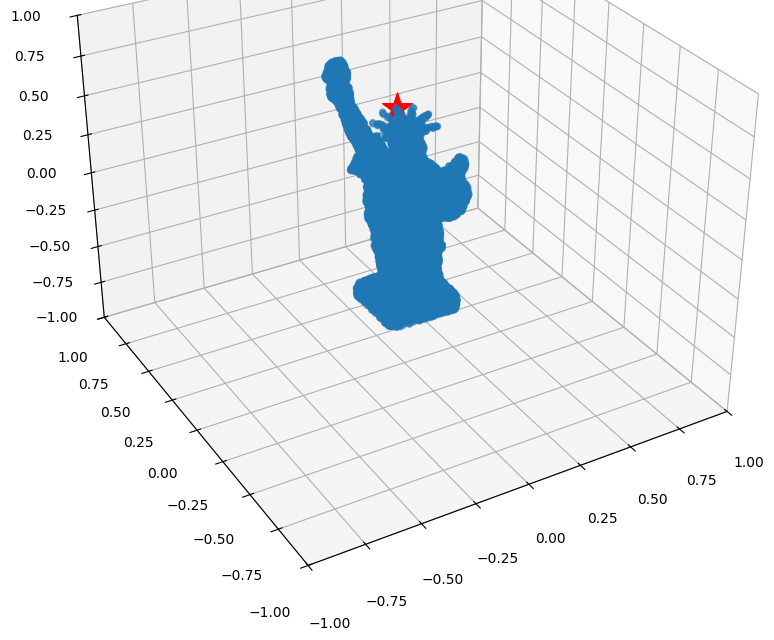

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
rand_index = np.random.permutation(len(pts))[:10000]
ax.scatter(pts[rand_index,0], pts[rand_index,2], pts[rand_index,1], alpha=0.5)
ax.scatter(pts[0,0], pts[0,2], pts[0,1], color='red', marker='*', s=500)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.view_init(30, -120)
ax.set_box_aspect(None, zoom=2)

### Step 3: Look into the local neighbor of a specific point and scale appropriately.
#### ⚠️ It is very important to scale the point cloud so that your neighborhood radius is 1.
#### ⚠️ In this example, we want to apply a neighborhood radius 0.1, so we need to do `pts = pts / 0.1` so that the local neighborhood is within a unit ball with radius 1. 
#### ⚠️ If your x, y, z has different scale, make sure to scale them differently so that the local neighborhood lies in a unit ball with radius 1.
#### ⚠️ Note in the 3d plot, the x, y, z ranges are all (-1, 1).

pt_0 has 1012 neighbors.


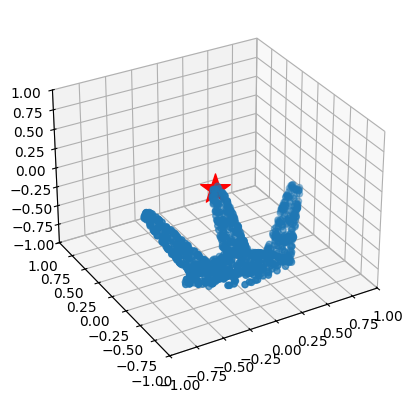

In [6]:
radius = 0.1 # neighborhood radius
pts = pts / radius # scale the point cloud so that the local neighborhood is within a unit ball with radius 1.

dist = np.linalg.norm(pts[0,:] - pts, axis=1)
nbr_idx = dist < 1
nbr_pts = pts[nbr_idx,:]
print(f'pt_0 has {len(nbr_pts)} neighbors.')

# centerize the local neighbor and visualize the local neighbor.
nbr_pts = nbr_pts - pts[0]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(nbr_pts[:,0], nbr_pts[:,2], nbr_pts[:,1])
ax.scatter(0,0,0, color='red', marker='*', s=500)
ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(-1, 1)
ax.view_init(30, -120)

In [7]:
np.linalg.norm(pts[0,:] - pts, axis=1)

array([ 0.        , 10.90552733, 12.10154213, ...,  6.87688939,
        5.02022479,  4.42949678])

### Step 4: Dense Local Geometry Encoding
#### ⚠️ If you scale the data appropriately according to Step 3, then it is safe to use the default `alpha` and `beta` parameters.
#### ⚠️ d=256, p=4096 is for point cloud size ~100k. 
#### ⚠️ You can use smaller p if point cloud size is smaller, and smaller d if neighborhood size is smaller.

In [8]:
vkm = VecKM()
pts = torch.tensor(pts).float()
print('The input is the point cloud with shape:', pts.shape)
G = vkm(pts)
print(f'The output is the dense geometry encoding with shape {G.shape}.')

The input is the point cloud with shape: torch.Size([100000, 3])
The output is the dense geometry encoding with shape torch.Size([100000, 256]).


In [1]:
G

NameError: name 'G' is not defined

### Step 5: Check the quality of encoding.
#### ℹ️ The check is performed with a reconstruction test. 
#### ℹ️ We randomly sample a point and get its neighborhood.
#### ℹ️ We reconstruct the neighboring point cloud distribution from the encoding.

In [10]:
import matplotlib.cm as cm
def reconstruct(pt, pts, g, vkm):
    p = np.linspace(-1, 1, 50)
    xx, yy, zz = np.meshgrid(p, p, p)
    xx_c = (xx[1:,1:,1:] + xx[:-1,:-1,:-1]) / 2
    yy_c = (yy[1:,1:,1:] + yy[:-1,:-1,:-1]) / 2
    zz_c = (zz[1:,1:,1:] + zz[:-1,:-1,:-1]) / 2
    p = np.stack([xx_c.reshape(-1), yy_c.reshape(-1), zz_c.reshape(-1)], axis=1)
    p = torch.from_numpy(p).float()
    p = torch.exp(1j * (p @ vkm.A))
    score = (p @ g.conj()).abs() / torch.norm(g) / torch.norm(p, dim=1)
    
    thres = torch.sort(score)[0][-5000].item()
    score = score.detach().cpu().numpy()
    score = score.reshape(xx_c.shape)
    score_bool = score > thres
    score = (score - thres) / (score.max() - thres)
    
    colors = np.zeros(score.shape + (4,))
    colors[:,:,:,:3] = cm.viridis(score**0.3)[:,:,:,:3]
    colors[:,:,:,3] = score ** 0.3
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.voxels(xx, yy, zz, score_bool, facecolors=colors)
    ax.scatter(nbr_pts[:,0], nbr_pts[:,1], nbr_pts[:,2], s=10, color='red', alpha=0.5)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.grid(False)
    ax.view_init(30, -120)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
            
    plt.tight_layout()
    plt.show()

In [ ]:
vkm = VecKM(d=256, alpha=6, beta=1.8, p=4096)
G = vkm(pts)

In [24]:
pt = pts[0, :]
g = G[0]

In [35]:
p = np.linspace(-1, 1, 50)
xx, yy, zz = np.meshgrid(p, p, p)
xx_c = (xx[1:,1:,1:] + xx[:-1,:-1,:-1]) / 2
yy_c = (yy[1:,1:,1:] + yy[:-1,:-1,:-1]) / 2
zz_c = (zz[1:,1:,1:] + zz[:-1,:-1,:-1]) / 2
p = np.stack([xx_c.reshape(-1), yy_c.reshape(-1), zz_c.reshape(-1)], axis=1)
p = torch.from_numpy(p).float()
p = torch.exp(1j * (p @ vkm.A))
score = (p @ g.conj()).abs() / torch.norm(g) / torch.norm(p, dim=1)

In [40]:
torch.sort(score)[0]

tensor([1.8976e-04, 2.8450e-04, 3.0799e-04,  ..., 5.3460e-01, 5.3565e-01,
        5.3826e-01])

In [34]:
thres = torch.sort(score)[0][-5000].item()
score = score.detach().cpu().numpy()
score = score.reshape(xx_c.shape)
score_bool = score > thres
score = (score - thres) / (score.max() - thres)

#### Reconstruction test 1: alpha = 6

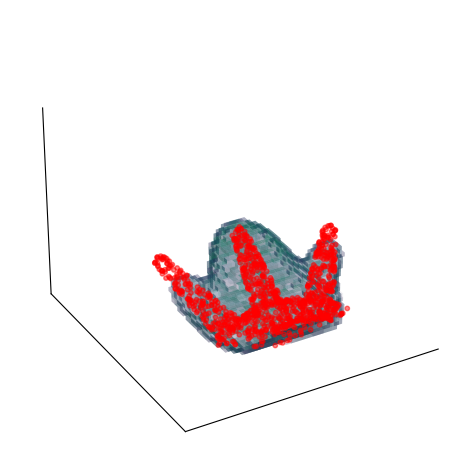

In [12]:
vkm = VecKM(d=256, alpha=6, beta=1.8, p=4096)
G = vkm(pts)
reconstruct(pts[0,:], pts, G[0,:], vkm)

#### Reconstruction test 2: alpha = 7
We may feel the detail of the local geometry is missed. Then we can slightly enlarge alpha.

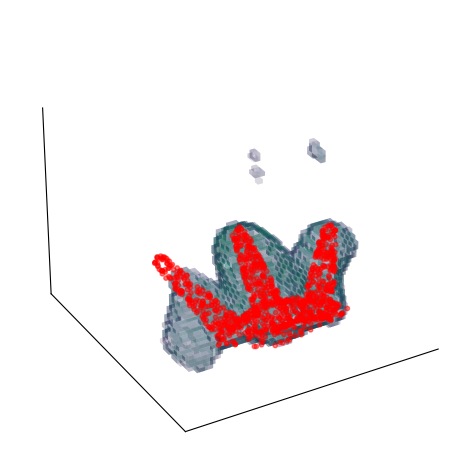

In [13]:
vkm = VecKM(d=256, alpha=7, beta=1.8, p=4096)
G = vkm(pts)
reconstruct(pts[0,:], pts, G[0,:], vkm)

#### Reconstruction Test 3: alpha = 8
Don't enlarge alpha too much since it also brings in noises.

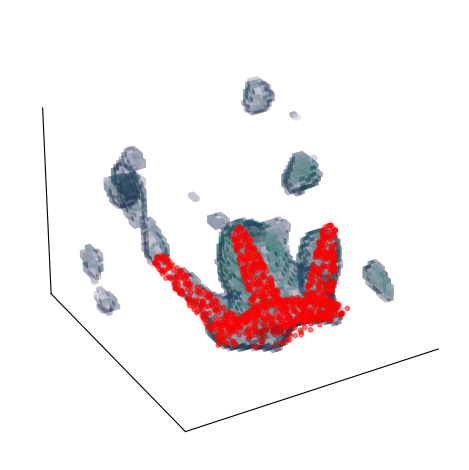

In [14]:
vkm = VecKM(d=256, alpha=8, beta=1.8, p=4096)
G = vkm(pts)
reconstruct(pts[0,:], pts, G[0,:], vkm)